<a href="https://colab.research.google.com/github/AlexandreSpinola/Previsao-de-ativos-LSTM---Multivariada/blob/main/multiplos_previsores_PETR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning A Z Recorrente - Múltiplos previsores

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

In [ ]:
np.__version__, pd.__version__, matplotlib.__version__, tf.__version__, sklearn.__version__

('2.0.2', '2.2.2', '3.10.0', '2.18.0', '1.6.1')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Importação da Base de dados

In [ ]:
import yfinance as yf

base_completa = yf.download('PETR4.SA', start='2022-01-01')
base_completa.reset_index(inplace=True)  #O yfinance.download() automaticamente define a coluna "Date" como índice, então tiramos date da função de indice

# Corrige o cabeçalho para remover MultiIndex (Ticker, BTC-USD → apenas 'Close', etc)
base_completa.columns = base_completa.columns.get_level_values(0)
base_completa

base_completa = base_completa.dropna()

/tmp/ipython-input-131-2530227518.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  base_completa = yf.download('PETR4.SA', start='2022-01-01')
[*********************100%***********************]  1 of 1 completed


In [ ]:
base_completa.shape

(869, 6)

#Indicadores

In [ ]:
Petra_Indicadores = base_completa.copy()

In [ ]:
Petra_Indicadores.head(30)

Price,Date,Close,High,Low,Open,Volume
0,2022-01-03,13.825017,13.886799,13.558877,13.563630,52704700
1,2022-01-04,13.877295,13.972345,13.739473,13.858285,51739200
2,2022-01-05,13.340262,13.910563,13.278480,13.872543,78459800
3,2022-01-06,13.330758,13.615908,13.230956,13.444819,61163100
4,2022-01-07,13.392541,13.444819,13.221451,13.359274,47507600
5,2022-01-10,13.311746,13.421053,13.173923,13.302240,37455200
6,2022-01-11,13.706203,13.815510,13.235705,13.354518,73623800
7,2022-01-12,14.124425,14.214723,13.758483,13.758483,81378200
8,2022-01-13,14.409575,14.556902,14.019870,14.034128,76717500
9,2022-01-14,14.946609,15.017896,14.371556,14.390566,96458800


<Figure size 1000x500 with 0 Axes>

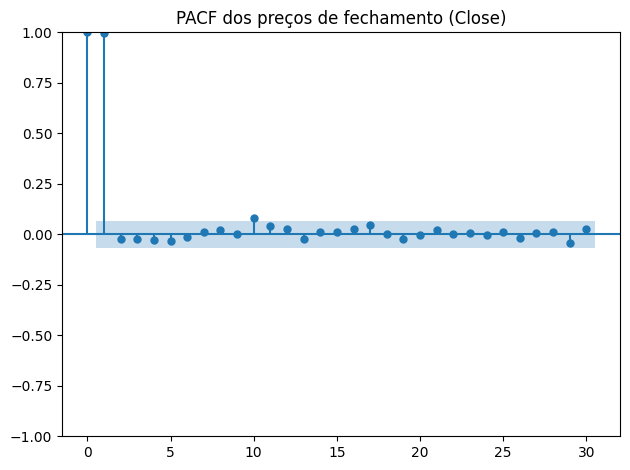

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# PACF até lag 30
plt.figure(figsize=(10, 5))
plot_pacf(Petra_Indicadores['Close'].dropna(), lags=30)
plt.title('PACF dos preços de fechamento (Close)')
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import pacf
import numpy as np

# Calcula PACF até lag 30
pacf_values = pacf(Petra_Indicadores['Close'].dropna(), nlags=30)

# Define um limiar de corte (ex: 95% de confiança)
limiar = 1.95 / np.sqrt(len(Petra_Indicadores['Close'].dropna()))

# Seleciona os lags com PACF maior que o limiar
lags_significativos = [i for i, val in enumerate(pacf_values) if i != 0 and abs(val) > limiar]

print("Lags significativos:", lags_significativos)


Lags significativos: [1, 10, 17, 29]


In [ ]:
# Criação dos lags
Petra_Indicadores['lag_3'] = Petra_Indicadores['Close'].shift(3)
Petra_Indicadores['lag_5'] = Petra_Indicadores['Close'].shift(5)
Petra_Indicadores['lag_10'] = Petra_Indicadores['Close'].shift(10)
Petra_Indicadores['lag_17'] = Petra_Indicadores['Close'].shift(15)

Petra_Indicadores.head(20)

Price,Date,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17
0,2022-01-03,13.825017,13.886799,13.558877,13.563630,52704700,NaN,NaN,NaN,NaN
1,2022-01-04,13.877295,13.972345,13.739473,13.858285,51739200,NaN,NaN,NaN,NaN
2,2022-01-05,13.340262,13.910563,13.278480,13.872543,78459800,NaN,NaN,NaN,NaN
3,2022-01-06,13.330758,13.615908,13.230956,13.444819,61163100,13.825017,NaN,NaN,NaN
4,2022-01-07,13.392541,13.444819,13.221451,13.359274,47507600,13.877295,NaN,NaN,NaN
5,2022-01-10,13.311746,13.421053,13.173923,13.302240,37455200,13.340262,13.825017,NaN,NaN
6,2022-01-11,13.706203,13.815510,13.235705,13.354518,73623800,13.330758,13.877295,NaN,NaN
7,2022-01-12,14.124425,14.214723,13.758483,13.758483,81378200,13.392541,13.340262,NaN,NaN
8,2022-01-13,14.409575,14.556902,14.019870,14.034128,76717500,13.311746,13.330758,NaN,NaN
9,2022-01-14,14.946609,15.017896,14.371556,14.390566,96458800,13.706203,13.392541,NaN,NaN


In [ ]:
for lag in lags_significativos:
    Petra_Indicadores[f'lag_{lag}'] = Petra_Indicadores['Close'].shift(lag)

In [ ]:
#Efeito calendário
Petra_Indicadores['day_of_week'] = Petra_Indicadores['Date'].dt.dayofweek  # 0=segunda, 6=domingo
Petra_Indicadores['is_month_end'] = Petra_Indicadores['Date'].dt.is_month_end.astype(int)
Petra_Indicadores['is_month_start'] = Petra_Indicadores['Date'].dt.is_month_start.astype(int)

Petra_Indicadores.iloc[20:30]

Price,Date,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17,lag_1,lag_29,day_of_week,is_month_end,is_month_start
20,2022-01-31,15.374331,15.683244,15.241261,15.445619,62450300,16.096708,15.184230,14.970368,13.330758,15.464630,NaN,0,1,0
21,2022-02-01,15.683243,15.835323,15.184231,15.374330,57315200,16.101461,15.678493,15.036901,13.392541,15.374331,NaN,1,0,1
22,2022-02-02,15.455126,15.916119,15.379086,15.878098,36271700,15.464630,16.096708,14.965618,13.311746,15.683243,NaN,2,0,0
23,2022-02-03,15.241258,15.645219,15.027396,15.374327,51087800,15.374331,16.101461,15.074924,13.706203,15.455126,NaN,3,0,0
24,2022-02-04,15.507403,15.792553,15.150965,15.402848,59346800,15.683243,15.464630,15.098686,14.124425,15.241258,NaN,4,0,0
25,2022-02-07,15.279281,15.578687,15.269775,15.469379,48868100,15.455126,15.374331,15.184230,14.409575,15.507403,NaN,0,0,0
26,2022-02-08,15.127201,15.184231,14.856309,15.160468,62590000,15.241258,15.683243,15.678493,14.946609,15.279281,NaN,1,0,0
27,2022-02-09,15.184230,15.535914,15.041654,15.084427,50960500,15.507403,15.455126,16.096708,14.970368,15.127201,NaN,2,0,0
28,2022-02-10,15.417102,15.635718,15.179478,15.350567,49534600,15.279281,15.241258,16.101461,15.036901,15.184230,NaN,3,0,0
29,2022-02-11,16.044432,16.115720,15.507401,15.573935,88013400,15.127201,15.507403,15.464630,14.965618,15.417102,13.825017,4,0,0


/tmp/ipython-input-140-882316900.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-140-882316900.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


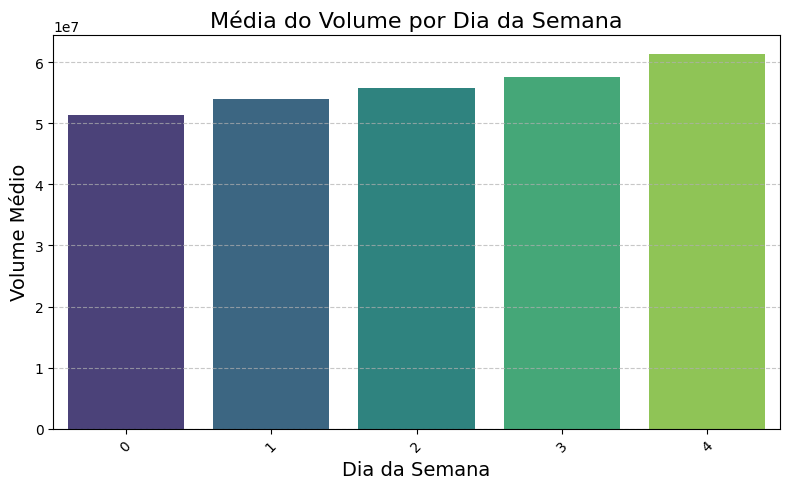

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

'''
# Mapeia os números dos dias para nomes
dias_semana = {
    0: 'Segunda-feira',
    1: 'Terça-feira',
    2: 'Quarta-feira',
    3: 'Quinta-feira',
    4: 'Sexta-feira',
    5: 'Sábado',
    6: 'Domingo'
}

Petra_Indicadores['day_of_week_name'] = Petra_Indicadores['day_of_week'].map(dias_semana)

 x='day_of_week_name',

'''

# Gráfico de barras da média de volume por dia da semana
plt.figure(figsize=(8, 5))
sns.barplot(
    data=Petra_Indicadores,
    x='day_of_week',
    y='Volume',
    estimator='mean',
    ci=None,
    palette='viridis'
)

plt.title('Média do Volume por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=14)
plt.ylabel('Volume Médio', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/tmp/ipython-input-141-543946558.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


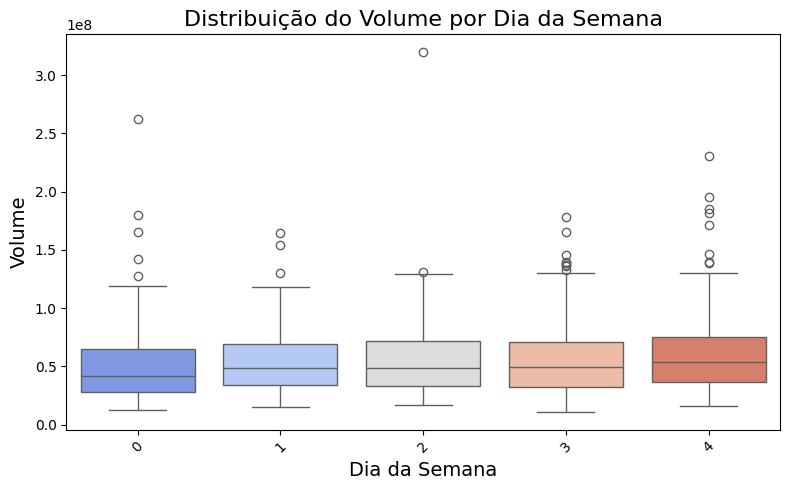

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=Petra_Indicadores,
    x='day_of_week',
    y='Volume',
    palette='coolwarm'
)

plt.title('Distribuição do Volume por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-142-2045106942.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-142-2045106942.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


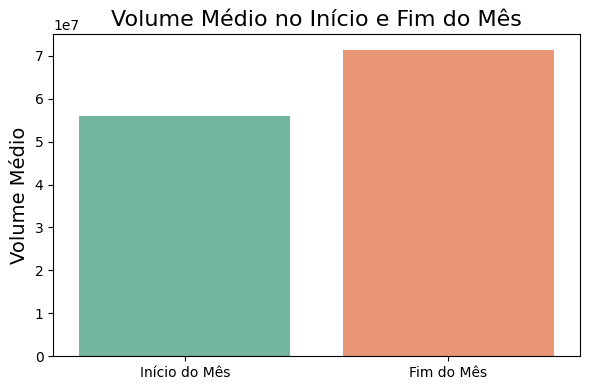

In [ ]:
# Junta as flags em um dataframe auxiliar
df_calendar_flags = Petra_Indicadores.melt(
    id_vars=['Volume'],
    value_vars=['is_month_start', 'is_month_end'],
    var_name='calendar_flag',
    value_name='flag'
)

# Filtra só os dias marcados como início/fim de mês
df_calendar_flags = df_calendar_flags[df_calendar_flags['flag'] == 1].copy()
df_calendar_flags['calendar_flag'] = df_calendar_flags['calendar_flag'].map({
    'is_month_start': 'Início do Mês',
    'is_month_end': 'Fim do Mês'
})

# Gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_calendar_flags,
    x='calendar_flag',
    y='Volume',
    estimator='mean',
    palette='Set2',
    ci=None
)

plt.title('Volume Médio no Início e Fim do Mês', fontsize=16)
plt.ylabel('Volume Médio', fontsize=14)
plt.xlabel('')
plt.tight_layout()
plt.show()


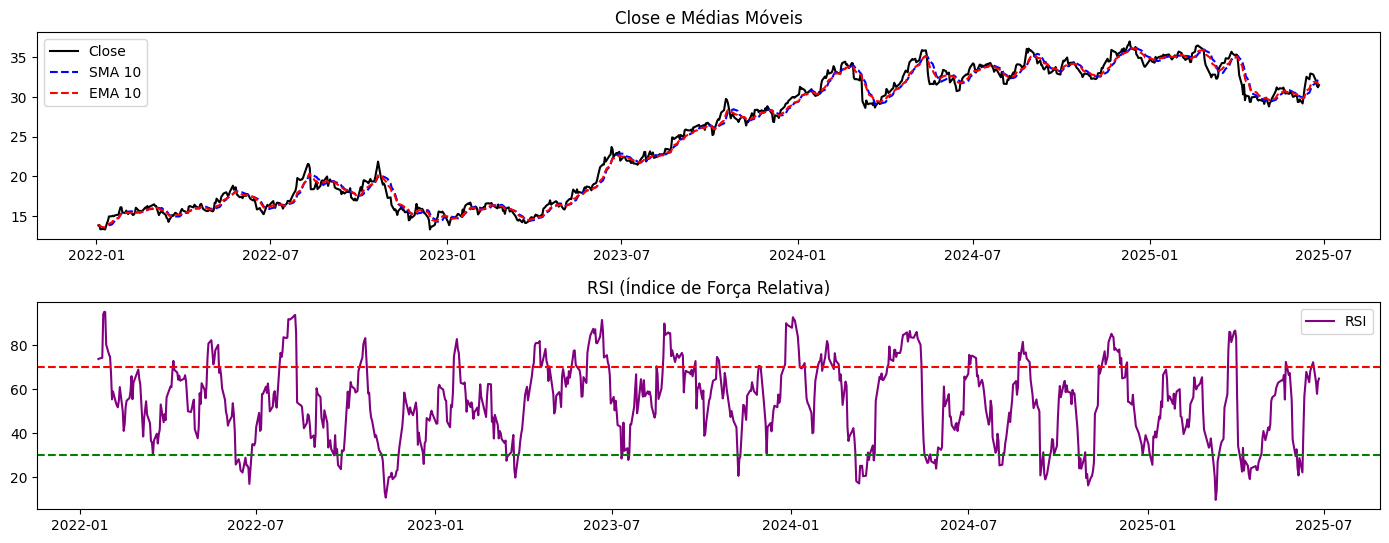

In [ ]:
# Cálculo da Média Móvel Simples (SMA)
Petra_Indicadores["SMA_10"] =Petra_Indicadores["Close"].rolling(window=10).mean()
Petra_Indicadores["SMA_20"] =Petra_Indicadores["Close"].rolling(window=20).mean()

# Crossover(ex: média móvel curta cruzando longa)
Petra_Indicadores['sma_crossover'] = (Petra_Indicadores['SMA_10'] > Petra_Indicadores['SMA_20']).astype(int)

# Cálculo da Média Móvel Exponencial (EMA)
Petra_Indicadores["EMA_10"] =Petra_Indicadores["Close"].ewm(span=10, adjust=False).mean()

# Cálculo do RSI (Relative Strength Index)
window_rsi = 14
delta =Petra_Indicadores["Close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

avg_gain = pd.Series(gain).rolling(window=window_rsi).mean()
avg_loss = pd.Series(loss).rolling(window=window_rsi).mean()
rs = avg_gain / avg_loss
Petra_Indicadores["RSI"] = 100 - (100 / (1 + rs))


# Cálculo do Estocástico
low_14 = Petra_Indicadores["Close"].rolling(window=14).min()
high_14 = Petra_Indicadores["Close"].rolling(window=14).max()
Petra_Indicadores["Estocástico"] = 100 * (Petra_Indicadores["Close"] - low_14) / (high_14 - low_14)

# Criar gráficos para visualizar os indicadores
plt.figure(figsize=(14, 8))

# Gráfico de InPetra_Indicadores + Médias Móveis
plt.subplot(3, 1, 1)
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["Close"], label="Close", color="black")
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["SMA_10"], label="SMA 10", linestyle="dashed", color="blue")
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["EMA_10"], label="EMA 10", linestyle="dashed", color="red")
plt.legend()
plt.title("Close e Médias Móveis")

# Gráfico do RSI
plt.subplot(3, 1, 2)
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["RSI"], label="RSI", color="purple")
plt.axhline(70, linestyle="dashed", color="red")
plt.axhline(30, linestyle="dashed", color="green")
plt.legend()
plt.title("RSI (Índice de Força Relativa)")

plt.tight_layout()

Price       Date      Close       High        Low       Open  Volume  \
0     2022-01-03  13.825017  13.886799  13.558877  13.563630     807   
1     2022-01-04  13.877295  13.972345  13.739473  13.858285     560   
2     2022-01-05  13.340262  13.910563  13.278480  13.872543     399   
3     2022-01-06  13.330758  13.615908  13.230956  13.444819     200   
4     2022-01-07  13.392541  13.444819  13.221451  13.359274     583   
5     2022-01-10  13.311746  13.421053  13.173923  13.302240     897   
6     2022-01-11  13.706203  13.815510  13.235705  13.354518     955   
7     2022-01-12  14.124425  14.214723  13.758483  13.758483     900   
8     2022-01-13  14.409575  14.556902  14.019870  14.034128     793   
9     2022-01-14  14.946609  15.017896  14.371556  14.390566     291   
10    2022-01-17  14.970368  15.117696  14.851556  14.922843     446   
11    2022-01-18  15.036901  15.198486  14.718484  14.998882     262   
12    2022-01-19  14.965618  15.307798  14.941856  15.160471    

Text(0.5, 1.0, 'On Balance Volume (OBV)')

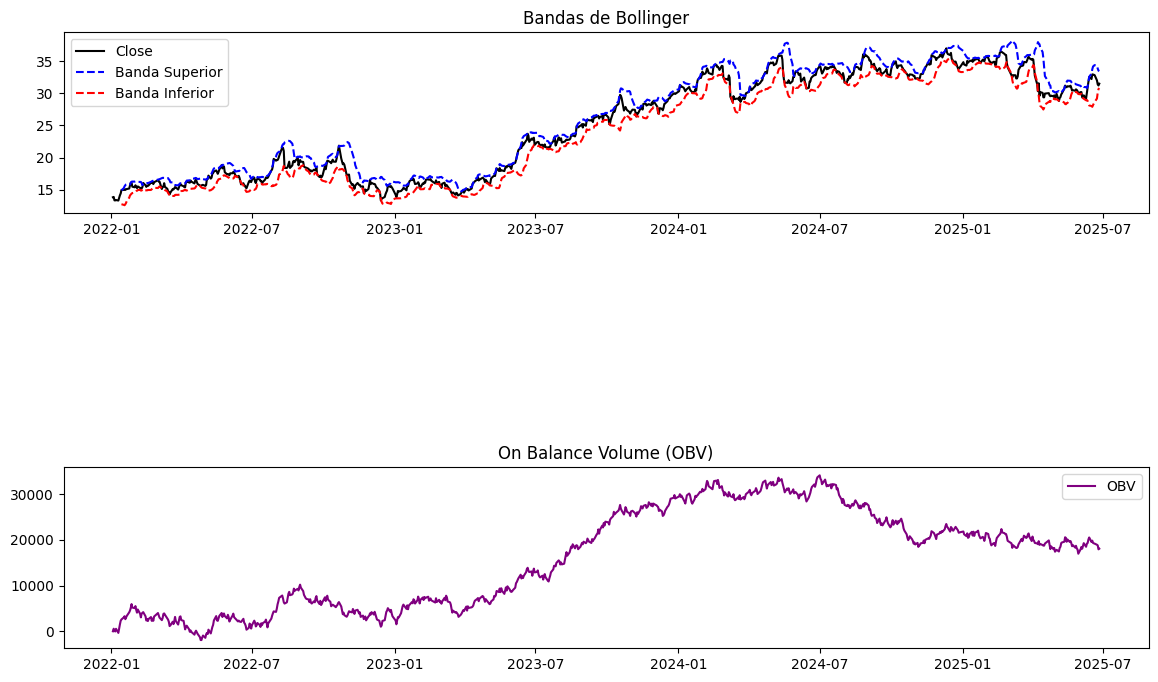

In [ ]:
# Bandas de Bollinger (SMA 10 + 2 desvios padrão)
Petra_Indicadores["SMA_10"] = Petra_Indicadores["Close"].rolling(window=10).mean()
Petra_Indicadores["STD_10"] = Petra_Indicadores["Close"].rolling(window=10).std()
Petra_Indicadores["Bollinger_Upper"] = Petra_Indicadores["SMA_10"] + 2 * Petra_Indicadores["STD_10"]
Petra_Indicadores["Bollinger_Lower"] = Petra_Indicadores["SMA_10"] - 2 * Petra_Indicadores["STD_10"]

# OBV (On Balance Volume)
volume = np.random.randint(100, 1000, len(Petra_Indicadores))  # Simula volume de negociações
Petra_Indicadores["Volume"] = volume
Petra_Indicadores["OBV"] = np.where(Petra_Indicadores["Close"] > Petra_Indicadores["Close"].shift(1), Petra_Indicadores["Volume"],
                     np.where(Petra_Indicadores["Close"] < Petra_Indicadores["Close"].shift(1), -Petra_Indicadores["Volume"], 0)).cumsum()

# Exibir as primeiras linhas com os novos indicadores
print(Petra_Indicadores.head(20))

# Criar gráficos para visualizar os indicadores
plt.figure(figsize=(14, 8))

# Bandas de Bollinger
plt.subplot(3, 1, 1)
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["Close"], label="Close", color="black")
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["Bollinger_Upper"], label="Banda Superior", linestyle="dashed", color="blue")
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["Bollinger_Lower"], label="Banda Inferior", linestyle="dashed", color="red")
plt.legend()
plt.title("Bandas de Bollinger")

# OBV
plt.subplot(3, 1, 3)
plt.plot(Petra_Indicadores["Date"], Petra_Indicadores["OBV"], label="OBV", color="purple")
plt.legend()
plt.title("On Balance Volume (OBV)")


In [ ]:
Petra_Indicadores.head(30)

Price,Date,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17,...,SMA_10,SMA_20,sma_crossover,EMA_10,RSI,Estocástico,STD_10,Bollinger_Upper,Bollinger_Lower,OBV
0,2022-01-03,13.825017,13.886799,13.558877,13.563630,807,NaN,NaN,NaN,NaN,...,NaN,NaN,0,13.825017,NaN,NaN,NaN,NaN,NaN,0
1,2022-01-04,13.877295,13.972345,13.739473,13.858285,560,NaN,NaN,NaN,NaN,...,NaN,NaN,0,13.834522,NaN,NaN,NaN,NaN,NaN,560
2,2022-01-05,13.340262,13.910563,13.278480,13.872543,399,NaN,NaN,NaN,NaN,...,NaN,NaN,0,13.744657,NaN,NaN,NaN,NaN,NaN,161
3,2022-01-06,13.330758,13.615908,13.230956,13.444819,200,13.825017,NaN,NaN,NaN,...,NaN,NaN,0,13.669402,NaN,NaN,NaN,NaN,NaN,-39
4,2022-01-07,13.392541,13.444819,13.221451,13.359274,583,13.877295,NaN,NaN,NaN,...,NaN,NaN,0,13.619064,NaN,NaN,NaN,NaN,NaN,544
5,2022-01-10,13.311746,13.421053,13.173923,13.302240,897,13.340262,13.825017,NaN,NaN,...,NaN,NaN,0,13.563188,NaN,NaN,NaN,NaN,NaN,-353
6,2022-01-11,13.706203,13.815510,13.235705,13.354518,955,13.330758,13.877295,NaN,NaN,...,NaN,NaN,0,13.589191,NaN,NaN,NaN,NaN,NaN,602
7,2022-01-12,14.124425,14.214723,13.758483,13.758483,900,13.392541,13.340262,NaN,NaN,...,NaN,NaN,0,13.686506,NaN,NaN,NaN,NaN,NaN,1502
8,2022-01-13,14.409575,14.556902,14.019870,14.034128,793,13.311746,13.330758,NaN,NaN,...,NaN,NaN,0,13.817973,NaN,NaN,NaN,NaN,NaN,2295
9,2022-01-14,14.946609,15.017896,14.371556,14.390566,291,13.706203,13.392541,NaN,NaN,...,13.826443,NaN,0,14.023179,NaN,NaN,0.541183,14.908809,12.744077,2586


In [ ]:
base_sem_nulos = Petra_Indicadores.iloc[19:] # alguns indicadores geram valores nulos nos seus primeiros dias, por isso a nova base começara a partir do di 27
base_sem_nulos

Price,Date,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17,...,SMA_10,SMA_20,sma_crossover,EMA_10,RSI,Estocástico,STD_10,Bollinger_Upper,Bollinger_Lower,OBV
19,2022-01-28,15.464630,16.324831,15.312550,16.063444,754,15.678493,15.098686,14.946609,13.340262,...,15.367202,14.596823,1,15.342671,80.159931,73.412841,0.446786,16.260775,14.473629,5193
20,2022-01-31,15.374331,15.683244,15.241261,15.445619,137,16.096708,15.184230,14.970368,13.330758,...,15.407598,14.674288,1,15.348428,75.545946,63.221170,0.424633,16.256864,14.558333,5056
21,2022-02-01,15.683243,15.835323,15.184231,15.374330,450,16.101461,15.678493,15.036901,13.392541,...,15.472232,14.764586,1,15.409303,74.698868,75.280936,0.410908,16.294048,14.650417,5506
22,2022-02-02,15.455126,15.916119,15.379086,15.878098,838,15.464630,16.096708,14.965618,13.311746,...,15.521183,14.870329,1,15.417634,66.871275,44.033078,0.371076,16.263336,14.779031,4668
23,2022-02-03,15.241258,15.645219,15.027396,15.374327,598,15.374331,16.101461,15.074924,13.706203,...,15.537817,14.965854,1,15.385566,55.308137,24.267391,0.352093,16.242002,14.833632,4070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,2025-06-20,32.820000,33.160000,32.630001,32.730000,137,32.209999,31.750000,29.360001,30.607670,...,31.509999,30.823361,1,31.868502,72.186886,96.817003,1.434240,34.378479,28.641520,19160
865,2025-06-23,32.000000,33.340000,31.809999,33.290001,242,32.939999,32.529999,29.670000,30.510595,...,31.742999,30.899287,1,31.892411,63.048394,75.066340,1.283442,34.309883,29.176116,18918
866,2025-06-24,31.370001,31.840000,31.139999,31.290001,139,32.910000,32.209999,29.170000,30.326153,...,31.963000,30.948567,1,31.797427,57.798173,58.355480,0.934512,33.832023,30.093976,18779
867,2025-06-25,31.209999,31.540001,31.209999,31.320000,863,32.820000,32.939999,30.049999,29.996098,...,32.079000,30.978684,1,31.690622,63.362065,54.111400,0.717456,33.513911,30.644088,17916


In [ ]:
base_sem_nulos.isnull().sum()

,0
Price,
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0
lag_3,0
lag_5,0
lag_10,0


In [ ]:
base_sem_nulos = base_sem_nulos.dropna()

# Normalização e Base de treinamento

In [ ]:
base_sem_nulos.shape

(840, 25)

In [ ]:
# Remove os 30 ultimos registros
base_treinamento = base_sem_nulos.iloc[:-30]
base_treinamento

Price,Date,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17,...,SMA_10,SMA_20,sma_crossover,EMA_10,RSI,Estocástico,STD_10,Bollinger_Upper,Bollinger_Lower,OBV
29,2022-02-11,16.044432,16.115720,15.507401,15.573935,176,15.127201,15.507403,15.464630,14.965618,...,15.431361,15.399281,1,15.459279,60.864321,94.146357,0.271203,15.973766,14.888955,4193
30,2022-02-14,15.683243,16.129977,15.597698,16.091958,926,15.184230,15.279281,15.374331,15.074924,...,15.462252,15.434925,1,15.500000,50.062070,57.073218,0.281387,16.025026,14.899478,3267
31,2022-02-15,15.436113,15.531164,15.155716,15.521658,905,15.417102,15.127201,15.683243,15.098686,...,15.437539,15.454886,0,15.488384,40.962338,31.707365,0.270462,15.978462,14.896615,2362
32,2022-02-16,15.649975,16.015917,15.573935,15.602451,339,16.044432,15.184230,15.455126,15.184230,...,15.457024,15.489103,0,15.517764,44.157460,56.994799,0.278761,16.014546,14.899502,2701
33,2022-02-17,15.588190,15.821063,15.469378,15.611952,462,15.683243,15.417102,15.241258,15.678493,...,15.491717,15.514767,0,15.530569,51.878530,50.258789,0.270387,16.032491,14.950943,2239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,2025-05-08,29.811655,30.122296,29.559262,29.695166,799,28.792372,29.112719,29.675753,29.584812,...,29.464129,29.734471,0,29.589065,54.475530,83.333151,0.335085,30.134299,28.793959,19280
835,2025-05-09,30.005806,30.267908,29.743704,30.190249,144,29.268038,29.908731,29.539848,30.172152,...,29.510725,29.719049,0,29.664836,56.187592,99.206274,0.376609,30.263942,28.757507,19424
836,2025-05-12,30.724159,31.228947,30.724159,30.966846,151,29.403944,28.792372,29.627214,30.058472,...,29.620419,29.677969,0,29.857440,57.326010,100.000000,0.539035,30.698490,28.542349,19575
837,2025-05-13,31.190119,31.306607,30.432935,30.840649,975,29.811655,29.268038,29.510725,29.366930,...,29.788359,29.758234,1,30.099745,60.306647,100.000000,0.729149,31.246656,28.330062,20550


In [ ]:
base_treinamento = base_treinamento.iloc[:, 1:25].values

In [ ]:
base_treinamento.shape

(810, 24)

In [ ]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [ ]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.11557057],
       [0.1003133 ],
       [0.08987411],
       [0.098908  ],
       [0.0962981 ],
       [0.1003133 ],
       [0.11737735],
       [0.11516917],
       [0.12480533],
       [0.10814264],
       [0.12038873],
       [0.13383914],
       [0.12520681],
       [0.12500611],
       [0.07622279],
       [0.08947254],
       [0.09148022],
       [0.11436621],
       [0.09007489],
       [0.07762813],
       [0.06217004],
       [0.05674962],
       [0.04028775],
       [0.0523331 ],
       [0.07541975],
       [0.07260931],
       [0.08124169],
       [0.08866955],
       [0.08626055],
       [0.07220767],
       [0.08626055],
       [0.10011268],
       [0.10934711],
       [0.100514  ],
       [0.0942907 ],
       [0.08806721],
       [0.08746495],
       [0.12119169],
       [0.12460463],
       [0.11938507],
       [0.11737735],
       [0.13183166],
       [0.12458956],
       [0.11251025],
       [0.13293531],
       [0.13622965],
       [0.10899623],
       [0.099

In [ ]:
base_treinamento_normalizada

array([[0.11557057, 0.10287483, 0.11123044, ..., 0.05252876, 0.09575037,
        0.16962004],
       [0.1003133 , 0.10348329, 0.1150453 , ..., 0.05471389, 0.09621472,
        0.14390068],
       [0.08987411, 0.07792727, 0.09637248, ..., 0.05272897, 0.09608839,
        0.11876458],
       ...,
       [0.73566883, 0.74787374, 0.7541069 , ..., 0.68022346, 0.69826082,
        0.59685035],
       [0.7553518 , 0.75118813, 0.74180329, ..., 0.70359102, 0.68889281,
        0.62393067],
       [0.7463304 , 0.74580227, 0.75615752, ..., 0.71668269, 0.68690664,
        0.62015332]])

# Treinamento

In [ ]:
base_treinamento.shape #esse é o numero de registros (numero de dias, pois estamos pegando os valores de forma diaria, e as colunas que representam os atributos que serão utilizados)

(810, 24)

In [ ]:
tam_base = len(base_treinamento)
len(base_treinamento)

810

In [ ]:
base_treinamento.shape[1] #número de colunas

24

In [ ]:
tam_colunas = (base_treinamento.shape[1])
tam_colunas

24

In [ ]:
X = [] # previsores
y = [] # preço real
for i in range(90, tam_base): # 90 preços anteriores
  X.append(base_treinamento_normalizada[i - 90:i, 0:tam_colunas])
  y.append(base_treinamento_normalizada[i, 0])
  #print(i, i - 90)
X, y = np.array(X), np.array(y)

In [ ]:
X[0], y[0]

(array([[0.11557057, 0.10287483, 0.11123044, ..., 0.05252876, 0.09575037,
         0.16962004],
        [0.1003133 , 0.10348329, 0.1150453 , ..., 0.05471389, 0.09621472,
         0.14390068],
        [0.08987411, 0.07792727, 0.09637248, ..., 0.05272897, 0.09608839,
         0.11876458],
        ...,
        [0.10034738, 0.11140455, 0.10939188, ..., 0.15465736, 0.11531613,
         0.10534941],
        [0.09838929, 0.09632092, 0.10204833, ..., 0.14674324, 0.104742  ,
         0.09843351],
        [0.08615218, 0.09211743, 0.09543941, ..., 0.13707855, 0.09419031,
         0.08554605]]),
 np.float64(0.08125727973842523))

In [ ]:
X.shape

(720, 90, 24)

In [ ]:
y.shape

(720,)

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences=True, input_shape = (X.shape[1], tam_colunas))) # 23 é o número de colunas
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'linear'))

regressor.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 90, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 90, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 90, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,651 (471.29 KB)

 Trainable params: 120,651 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1) # 0.00000..1
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='pesos.keras', monitor='loss', save_best_only=True, verbose = 1)

In [ ]:
regressor.fit(X, y, epochs = 100, batch_size=32, callbacks=[es, rlr, mcp])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1120 - mean_absolute_error: 0.2447
Epoch 1: loss improved from inf to 0.05381, saving model to pesos.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.1096 - mean_absolute_error: 0.2415 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0174 - mean_absolute_error: 0.1017
Epoch 2: loss improved from 0.05381 to 0.01521, saving model to pesos.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - loss: 0.0173 - mean_absolute_error: 0.1013 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0132 - mean_absolute_error: 0.0873
Epoch 3: loss improved from 0.01521 to 0.01151, saving model to pesos.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.0131 - mean_absolute_error: 0.0871 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0121 - mean_absolute_error: 0.0833
Epoch 4: loss did not improve from 0.01151
23/23 ━━━━

# Previsão

In [ ]:
base_teste = base_sem_nulos.tail(30)
base_teste

Price,Date,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17,...,SMA_10,SMA_20,sma_crossover,EMA_10,RSI,Estocástico,STD_10,Bollinger_Upper,Bollinger_Lower,OBV
839,2025-05-15,30.937725,31.151289,30.665915,30.772698,845,30.724159,29.811655,29.112719,29.947561,...,30.101910,29.842417,1,30.382539,62.765966,89.473714,0.820784,31.743477,28.460343,19569
840,2025-05-16,31.083336,31.219240,30.733866,30.908601,508,31.190119,30.005806,29.908731,30.015514,...,30.219371,29.928237,1,30.509957,63.157902,95.546531,0.872486,31.964342,28.474399,20077
841,2025-05-19,31.044506,31.160995,30.772698,30.908602,541,30.976553,30.724159,28.792372,29.675753,...,30.444584,30.012116,1,30.607148,64.056945,93.927103,0.744490,31.933565,28.955604,19536
842,2025-05-20,31.170704,31.461927,31.015384,31.112458,175,30.937725,31.190119,29.268038,29.539848,...,30.634851,30.073273,1,30.709612,63.864055,99.190286,0.647162,31.929174,29.340527,19711
843,2025-05-21,30.821234,31.442512,30.762989,31.267777,462,31.083336,30.976553,29.403944,29.627214,...,30.776580,30.113559,1,30.729907,66.356872,84.615348,0.481676,31.739931,29.813228,19249
844,2025-05-22,30.413521,30.724160,30.297030,30.714452,651,31.044506,30.937725,29.811655,29.510725,...,30.836766,30.150448,1,30.672382,55.220891,67.611347,0.373067,31.582900,30.090632,18598
845,2025-05-23,30.481472,30.481472,29.966977,30.180541,240,31.170704,31.083336,30.005806,29.666044,...,30.884333,30.197529,1,30.637671,72.307698,63.131274,0.271973,31.428279,30.340387,18838
846,2025-05-26,30.384398,30.607671,30.229078,30.539717,538,30.821234,31.044506,30.724159,29.112719,...,30.850357,30.235388,1,30.591622,66.381776,54.891241,0.312421,31.475198,30.225515,18300
847,2025-05-27,30.607670,30.743574,30.442643,30.597962,388,30.413521,31.170704,31.190119,29.908731,...,30.792112,30.290235,1,30.594540,67.222221,57.746516,0.295897,31.383905,30.200318,18688
848,2025-05-28,30.510595,30.792111,30.510595,30.743575,565,30.481472,30.821234,30.976553,28.792372,...,30.745516,30.332463,1,30.579277,60.975643,42.622975,0.300281,31.346077,30.144955,18123


In [ ]:
y_teste = base_teste.iloc[:, 1:2].values
y_teste

array([[30.93772507],
       [31.08333588],
       [31.04450607],
       [31.17070389],
       [30.82123375],
       [30.41352081],
       [30.48147202],
       [30.38439751],
       [30.60766983],
       [30.51059532],
       [30.3261528 ],
       [29.99609756],
       [30.17083359],
       [30.18000031],
       [29.35000038],
       [29.36000061],
       [29.67000008],
       [29.17000008],
       [30.04999924],
       [31.04999924],
       [31.75      ],
       [32.52999878],
       [32.20999908],
       [32.93999863],
       [32.90999985],
       [32.81999969],
       [32.        ],
       [31.37000084],
       [31.20999908],
       [31.48999977]])

In [ ]:
base_treinamento2 = base_sem_nulos.iloc[:-30]

In [ ]:
frames = [base_treinamento2, base_teste]

In [ ]:
frames

[Price       Date      Close       High        Low       Open  Volume  \
 29    2022-02-11  16.044432  16.115720  15.507401  15.573935     176   
 30    2022-02-14  15.683243  16.129977  15.597698  16.091958     926   
 31    2022-02-15  15.436113  15.531164  15.155716  15.521658     905   
 32    2022-02-16  15.649975  16.015917  15.573935  15.602451     339   
 33    2022-02-17  15.588190  15.821063  15.469378  15.611952     462   
 ..           ...        ...        ...        ...        ...     ...   
 834   2025-05-08  29.811655  30.122296  29.559262  29.695166     799   
 835   2025-05-09  30.005806  30.267908  29.743704  30.190249     144   
 836   2025-05-12  30.724159  31.228947  30.724159  30.966846     151   
 837   2025-05-13  31.190119  31.306607  30.432935  30.840649     975   
 838   2025-05-14  30.976553  31.180409  30.772697  31.063920     136   
 
 Price      lag_3      lag_5     lag_10     lag_17  ...     SMA_10     SMA_20  \
 29     15.127201  15.507403  15.464630  

In [ ]:
base_completa = pd.concat(frames)
base_completa

Price,Date,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17,...,SMA_10,SMA_20,sma_crossover,EMA_10,RSI,Estocástico,STD_10,Bollinger_Upper,Bollinger_Lower,OBV
29,2022-02-11,16.044432,16.115720,15.507401,15.573935,176,15.127201,15.507403,15.464630,14.965618,...,15.431361,15.399281,1,15.459279,60.864321,94.146357,0.271203,15.973766,14.888955,4193
30,2022-02-14,15.683243,16.129977,15.597698,16.091958,926,15.184230,15.279281,15.374331,15.074924,...,15.462252,15.434925,1,15.500000,50.062070,57.073218,0.281387,16.025026,14.899478,3267
31,2022-02-15,15.436113,15.531164,15.155716,15.521658,905,15.417102,15.127201,15.683243,15.098686,...,15.437539,15.454886,0,15.488384,40.962338,31.707365,0.270462,15.978462,14.896615,2362
32,2022-02-16,15.649975,16.015917,15.573935,15.602451,339,16.044432,15.184230,15.455126,15.184230,...,15.457024,15.489103,0,15.517764,44.157460,56.994799,0.278761,16.014546,14.899502,2701
33,2022-02-17,15.588190,15.821063,15.469378,15.611952,462,15.683243,15.417102,15.241258,15.678493,...,15.491717,15.514767,0,15.530569,51.878530,50.258789,0.270387,16.032491,14.950943,2239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,2025-06-20,32.820000,33.160000,32.630001,32.730000,137,32.209999,31.750000,29.360001,30.607670,...,31.509999,30.823361,1,31.868502,72.186886,96.817003,1.434240,34.378479,28.641520,19160
865,2025-06-23,32.000000,33.340000,31.809999,33.290001,242,32.939999,32.529999,29.670000,30.510595,...,31.742999,30.899287,1,31.892411,63.048394,75.066340,1.283442,34.309883,29.176116,18918
866,2025-06-24,31.370001,31.840000,31.139999,31.290001,139,32.910000,32.209999,29.170000,30.326153,...,31.963000,30.948567,1,31.797427,57.798173,58.355480,0.934512,33.832023,30.093976,18779
867,2025-06-25,31.209999,31.540001,31.209999,31.320000,863,32.820000,32.939999,30.049999,29.996098,...,32.079000,30.978684,1,31.690622,63.362065,54.111400,0.717456,33.513911,30.644088,17916


In [ ]:
base_completa = base_completa.drop('Date', axis = 1)
base_completa

Price,Close,High,Low,Open,Volume,lag_3,lag_5,lag_10,lag_17,lag_1,...,SMA_10,SMA_20,sma_crossover,EMA_10,RSI,Estocástico,STD_10,Bollinger_Upper,Bollinger_Lower,OBV
29,16.044432,16.115720,15.507401,15.573935,176,15.127201,15.507403,15.464630,14.965618,15.417102,...,15.431361,15.399281,1,15.459279,60.864321,94.146357,0.271203,15.973766,14.888955,4193
30,15.683243,16.129977,15.597698,16.091958,926,15.184230,15.279281,15.374331,15.074924,16.044432,...,15.462252,15.434925,1,15.500000,50.062070,57.073218,0.281387,16.025026,14.899478,3267
31,15.436113,15.531164,15.155716,15.521658,905,15.417102,15.127201,15.683243,15.098686,15.683243,...,15.437539,15.454886,0,15.488384,40.962338,31.707365,0.270462,15.978462,14.896615,2362
32,15.649975,16.015917,15.573935,15.602451,339,16.044432,15.184230,15.455126,15.184230,15.436113,...,15.457024,15.489103,0,15.517764,44.157460,56.994799,0.278761,16.014546,14.899502,2701
33,15.588190,15.821063,15.469378,15.611952,462,15.683243,15.417102,15.241258,15.678493,15.649975,...,15.491717,15.514767,0,15.530569,51.878530,50.258789,0.270387,16.032491,14.950943,2239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,32.820000,33.160000,32.630001,32.730000,137,32.209999,31.750000,29.360001,30.607670,32.910000,...,31.509999,30.823361,1,31.868502,72.186886,96.817003,1.434240,34.378479,28.641520,19160
865,32.000000,33.340000,31.809999,33.290001,242,32.939999,32.529999,29.670000,30.510595,32.820000,...,31.742999,30.899287,1,31.892411,63.048394,75.066340,1.283442,34.309883,29.176116,18918
866,31.370001,31.840000,31.139999,31.290001,139,32.910000,32.209999,29.170000,30.326153,32.000000,...,31.963000,30.948567,1,31.797427,57.798173,58.355480,0.934512,33.832023,30.093976,18779
867,31.209999,31.540001,31.209999,31.320000,863,32.820000,32.939999,30.049999,29.996098,31.370001,...,32.079000,30.978684,1,31.690622,63.362065,54.111400,0.717456,33.513911,30.644088,17916


In [ ]:
len(base_completa), len(base_teste), len(base_completa) - len(base_teste) - 90

(840, 30, 720)

In [ ]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values

In [ ]:
entradas

array([[   34.83296585,    35.13610804,    34.28351837, ...,
           36.56222618,    33.31401207, 21813.        ],
       [   34.46351242,    35.08874365,    34.4066719 , ...,
           36.27137357,    33.30930118, 21193.        ],
       [   34.30246735,    34.75718066,    34.16037147, ...,
           35.65800636,    33.52668831, 20801.        ],
       ...,
       [   31.37000084,    31.84000015,    31.13999939, ...,
           33.83202281,    30.09397626, 18779.        ],
       [   31.20999908,    31.54000092,    31.20999908, ...,
           33.51391145,    30.64408759, 17916.        ],
       [   31.48999977,    31.60000038,    31.30999947, ...,
           33.43979815,    30.80620099, 18056.        ]])

In [ ]:
entradas = normalizador.transform(entradas)
entradas

array([[0.90923225, 0.9146227 , 0.90448244, ..., 0.93018646, 0.9088295 ,
        0.65901011],
       [0.89362587, 0.9126013 , 0.90968542, ..., 0.91778781, 0.90862162,
        0.6417898 ],
       [0.88682304, 0.89845093, 0.89927974, ..., 0.89164081, 0.91821469,
        0.63090212],
       ...,
       [0.76295035, 0.77395215, 0.77167529, ..., 0.81380165, 0.76673258,
        0.5747417 ],
       [0.75619158, 0.76114885, 0.77463263, ..., 0.800241  , 0.79100844,
        0.55077214],
       [0.76801932, 0.76370949, 0.77885744, ..., 0.79708165, 0.79816234,
        0.55466059]])

In [ ]:
entradas.shape

(120, 24)

In [ ]:
X_teste = []
for i in range(90, 120):
    X_teste.append(entradas[i-90:i, 0:tam_colunas]) # 23 é o número de colunas
X_teste = np.array(X_teste)

In [ ]:
X_teste.shape

(30, 90, 24)

In [ ]:
previsoes = regressor.predict(X_teste)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


In [ ]:
previsoes

array([[0.76696086],
       [0.7752392 ],
       [0.77916014],
       [0.7815521 ],
       [0.78461766],
       [0.7882423 ],
       [0.79066753],
       [0.7908695 ],
       [0.79065114],
       [0.7913457 ],
       [0.7923571 ],
       [0.79087573],
       [0.78531426],
       [0.77901936],
       [0.7750888 ],
       [0.7734049 ],
       [0.7726765 ],
       [0.7721305 ],
       [0.772415  ],
       [0.77668214],
       [0.78728366],
       [0.8028202 ],
       [0.81941795],
       [0.83446145],
       [0.8463941 ],
       [0.8543407 ],
       [0.85712016],
       [0.8563205 ],
       [0.8521639 ],
       [0.8454545 ]], dtype=float32)

In [ ]:
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [ ]:
previsoes

array([[31.464943],
       [31.66092 ],
       [31.75374 ],
       [31.810364],
       [31.882936],
       [31.968742],
       [32.026157],
       [32.030937],
       [32.02577 ],
       [32.04221 ],
       [32.066154],
       [32.031082],
       [31.899426],
       [31.750406],
       [31.657358],
       [31.617493],
       [31.60025 ],
       [31.587324],
       [31.594059],
       [31.695078],
       [31.946049],
       [32.31385 ],
       [32.70677 ],
       [33.0629  ],
       [33.345383],
       [33.533504],
       [33.599304],
       [33.580376],
       [33.481976],
       [33.32314 ]], dtype=float32)

In [ ]:
y_teste

array([[30.93772507],
       [31.08333588],
       [31.04450607],
       [31.17070389],
       [30.82123375],
       [30.41352081],
       [30.48147202],
       [30.38439751],
       [30.60766983],
       [30.51059532],
       [30.3261528 ],
       [29.99609756],
       [30.17083359],
       [30.18000031],
       [29.35000038],
       [29.36000061],
       [29.67000008],
       [29.17000008],
       [30.04999924],
       [31.04999924],
       [31.75      ],
       [32.52999878],
       [32.20999908],
       [32.93999863],
       [32.90999985],
       [32.81999969],
       [32.        ],
       [31.37000084],
       [31.20999908],
       [31.48999977]])

In [ ]:
previsoes.mean()

np.float32(32.235287)

In [ ]:
y_teste.mean()

np.float64(30.93360799153646)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_teste, previsoes)

1.316088612874349

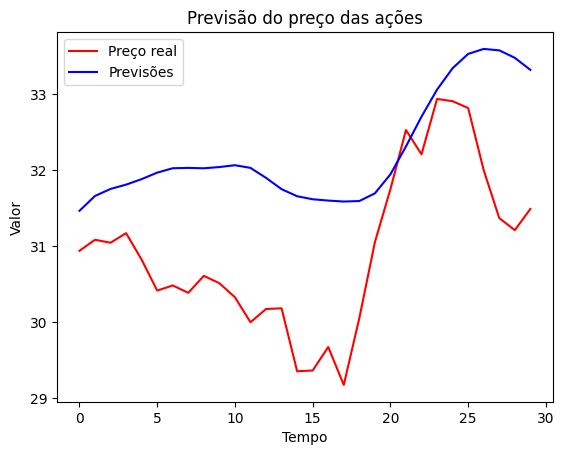

In [ ]:
plt.plot(y_teste, color = "red", label = "Preço real")
plt.plot(previsoes, color = "blue", label = "Previsões")
plt.title("Previsão do preço das ações")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend();